## Fraud detection Classifier

Semme Kaandorp <br>
11046244 <br>
University of Amsterdam <br>
March 30, 2020 <br>

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import time 
from collections import Counter
import findspark
import pyspark
import random
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

#import spark packages
from pyspark.sql import SparkSession 
from pyspark.sql.functions import to_timestamp
from pyspark.sql.types import StructType, StructField, StringType, IntegerType

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
#import packages for regular implementation
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from sklearn import metrics

from imblearn import under_sampling, over_sampling
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

### Load data

In [3]:
%%time
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('creditcard.csv', header= True, inferSchema = True)
#df.printSchema()

CPU times: user 34.3 ms, sys: 23.4 ms, total: 57.7 ms
Wall time: 19.4 s


In [4]:
#change Apache dataframe to Pandas Datafame
analysis = pd.DataFrame(df.take(284807), columns=df.columns)

#apparantly time was not a float
analysis['Time'] = analysis['Time'].astype('float64')
frauds = analysis[analysis.Class ==1]

In [5]:
#print imbalanceness of data set
X, y = analysis[list(analysis.columns[1:-1])], analysis['Class']
print('very imbalanced dataset:')
print(Counter(y))

very imbalanced dataset:
Counter({0: 284315, 1: 492})


apparantly not skewed distribution of fraud over time in proportion to number of transactions


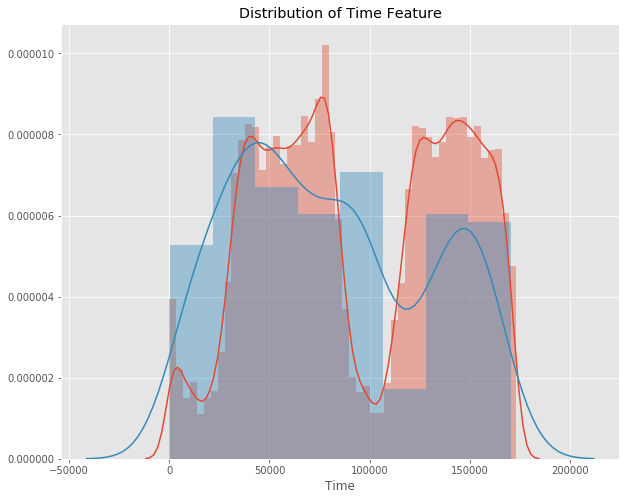

In [6]:
#print distribution of transaction and fraudcases over time
plt.figure(figsize=(10,8))
plt.title('Distribution of Time Feature')
sns.distplot(analysis.Time)
sns.distplot(frauds.Time)
print("apparantly not skewed distribution of fraud over time in proportion to number of transactions")

# Pandas Implementation

### No Data Sampling

In [7]:
#split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=402)
print(Counter(y))

Counter({0: 284315, 1: 492})


### Data Sampling

In [8]:
#sampling ratio
pos, neg = 98, 2
ratio = (1/(pos/neg))

### Undersampling

In [9]:
undersample = under_sampling.RandomUnderSampler(sampling_strategy=(ratio))

X_over, y_over = undersample.fit_resample(X, y)

#split data 
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=402)

print('normal: ', Counter(y))
print('sampling applied: ', Counter(y_over))

normal:  Counter({0: 284315, 1: 492})
sampling applied:  Counter({0: 24108, 1: 492})


### Oversampling

In [10]:
oversample = over_sampling.RandomOverSampler(sampling_strategy=(ratio))
X_over, y_over = oversample.fit_resample(X, y)

#split data 
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=402)

print('normal: ', Counter(y))
print('sampling applied: ', Counter(y_over))

normal:  Counter({0: 284315, 1: 492})
sampling applied:  Counter({0: 284315, 1: 5802})


### SMOTE

In [11]:
smote = over_sampling.SMOTE(sampling_strategy=(ratio))
X_over, y_over = smote.fit_resample(X, y)

#split data 
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state=402)

print('normal: ', Counter(y))
print('sampling applied: ', Counter(y_over))

normal:  Counter({0: 284315, 1: 492})
sampling applied:  Counter({0: 284315, 1: 5802})


### Logistic Regression

In [12]:
#training the model
lr_reg = LogisticRegression(n_jobs=10)

In [13]:
lr_reg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=10, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
#print table with actual/predicted classes
y_pred = lr_reg.predict(X_test)
table = pd.DataFrame({'Actual': y_test.ravel(), 'Predicted': lr_reg.predict(X_test).flatten()})

# predict probabilities, keep positive outcome only
lr_probs = lr_reg.predict_proba(X_test)[:,1]

# calculate precision and recall for each threshold
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)

# calculate PR score
lr_prr_auc = auc(lr_recall, lr_precision)

In [15]:
#print metrics
lr_accuracy = lr_reg.score(X_test, y_test)
lr_roc_auc = roc_auc_score(y_test, y_pred)
lr_precision = precision_score(y_test, y_pred, average='binary')
lr_recall = recall_score(y_test, y_pred, average='binary')

print('accuracy:', lr_accuracy)
print('ROC AUC:', round(lr_roc_auc, 5))
print('PreRec AUC:', round(lr_prr_auc,5))
print("Precision", round(lr_precision,5))
print("Recall",round(lr_recall,5))

accuracy: 0.996036122983593
ROC AUC: 0.9181
PreRec AUC: 0.91625
Precision 0.96059
Recall 0.83691


## Random Forest

In [16]:
# Instantiate model with 10 decision trees
rf_reg = RandomForestClassifier(n_estimators = 10, random_state = 41)

# Train the model on training data
rf_reg.fit(X_train, y_train);

In [17]:
#print table with actual/predicted classes
y_pred = rf_reg.predict(X_test)
table = pd.DataFrame({'Actual': y_test.ravel(), 'Predicted': rf_reg.predict(X_test).flatten()})

# predict probabilities, keep positive outcome only
rf_probs = rf_reg.predict_proba(X_test)[:,1]

# calculate precision and recall for each threshold
rf_precision, rf_recall, _ = precision_recall_curve(y_test, rf_probs)

# calculate PR score
rf_prr_auc = auc(rf_recall, rf_precision)

In [18]:
rf_accuracy = rf_reg.score(X_test, y_test)
rf_roc_auc = roc_auc_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred, average='binary')
rf_recall = recall_score(y_test, y_pred, average='binary')

print('accuracy:', rf_accuracy)
print('ROC AUC:', round(rf_roc_auc, 5))
print('PreRec AUC:', round(rf_prr_auc,5))
print("Precision", round(rf_precision,5))
print("Recall",round(rf_recall,5))

accuracy: 0.9983455122018475
ROC AUC: 0.96174
PreRec AUC: 0.98746
Precision 0.99354
Recall 0.92361


### Decision Tree

In [19]:
#training the algorithm
dt_reg = tree.DecisionTreeClassifier()
dt_reg.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [20]:
#print table with actual/predicted classes
y_pred = dt_reg.predict(X_test)
table = pd.DataFrame({'Actual': y_test.ravel(), 'Predicted': dt_reg.predict(X_test).flatten()})

# predict probabilities and keep positive outcomes only
dt_probs = dt_reg.predict_proba(X_test)[:,1]

# calculate precision and recall for each threshold
dt_precision, dt_recall, _ = precision_recall_curve(y_test, dt_probs)

# calculate PR score
dt_prr_auc = auc(dt_recall, dt_precision)

In [21]:
dt_accuracy = dt_reg.score(X_test, y_test)
dt_roc_auc = roc_auc_score(y_test, y_pred)
dt_precision = precision_score(y_test, y_pred, average='binary')
dt_recall = recall_score(y_test, y_pred, average='binary')

print('accuracy:', dt_accuracy)
print('ROC AUC:', round(dt_roc_auc, 5))
print('PreRec AUC:', round(dt_prr_auc,5))
print("Precision", round(dt_precision,5))
print("Recall",round(dt_recall,5))

accuracy: 0.9974148628153867
ROC AUC: 0.96841
PreRec AUC: 0.93641
Precision 0.93339
Recall 0.9382


# Apache Spark Implementation

In [22]:
#import packages for apache
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

bin_evaluator = BinaryClassificationEvaluator()
multi_evaluator = MulticlassClassificationEvaluator()

### Prepare data

In [23]:
df = spark.createDataFrame(analysis)

In [24]:
vectorAssembler = VectorAssembler(inputCols = ['V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13',
'V14','V15','V16','V17','V18','V19','V20','V21','V22', 'V23','V24','V25','V26','V27','V28','Amount'], outputCol = 'features')

df1 = vectorAssembler.transform(df)
df2 = df1.select(['features', 'Class'])
df3 = df2.withColumnRenamed("Class","label")

In [25]:
#randomly split data in train/test set
#validation set is not necessary since we're dealing with large amounts of data

train, test = df3.randomSplit([0.8, 0.2], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 227858
Test Dataset Count: 56949


### Logistic Regression

In [26]:
lr = LogisticRegression(maxIter=10)

# Fit the model
lrModel = lr.fit(train)

In [27]:
lr_predictions = lrModel.transform(test)
lr_predictions.show(3)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-27.84818067198,...|    1|[0.81640192543288...|[0.69347203541465...|       0.0|
|[-24.465548667359...|    0|[8.62905655492299...|[0.99982119869064...|       0.0|
|[-23.237920244511...|    1|[-2.0502865712633...|[0.11402342805069...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 3 rows



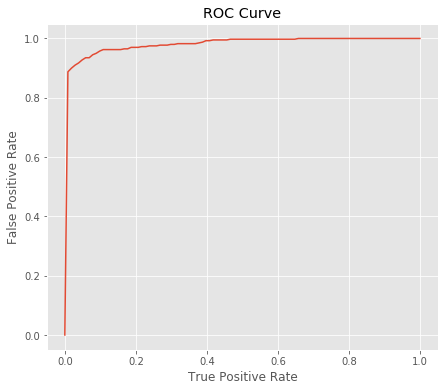

In [28]:
Summary = lrModel.summary
roc = Summary.roc.toPandas()
plt.figure(figsize=(7,6))
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

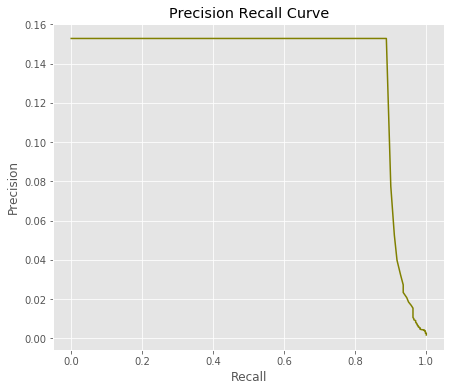

In [29]:
pr = Summary.pr.toPandas()
plt.figure(figsize=(7,6))
plt.plot(pr['recall'],pr['precision'], color='olive')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision Recall Curve')
plt.show()

In [30]:
print("Linear Regression")
print('AUC ROC: ', round(bin_evaluator.evaluate(lr_predictions),4))
print('AUC PR:  ', round(bin_evaluator.evaluate(lr_predictions, {bin_evaluator.metricName: "areaUnderPR"}),4))
print('Accuracy: ', round(multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "accuracy"}),4))
print('Precision: ', round(multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "weightedPrecision"}),4))
print('Recall: ', round(multi_evaluator.evaluate(lr_predictions, {multi_evaluator.metricName: "weightedRecall"}),4))

Linear Regression
AUC ROC:  0.9711
AUC PR:   0.7208
Accuracy:  0.9992
Precision:  0.9991
Recall:  0.9992


### Dicision Tree

In [31]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)

In [32]:
dt_predictions = dtModel.transform(test)
dt_predictions.show(3)

+--------------------+-----+---------------+--------------------+----------+
|            features|label|  rawPrediction|         probability|prediction|
+--------------------+-----+---------------+--------------------+----------+
|[-27.84818067198,...|    1|   [52.0,297.0]|[0.14899713467048...|       1.0|
|[-24.465548667359...|    0|[220878.0,50.0]|[0.99977368192352...|       0.0|
|[-23.237920244511...|    1|   [52.0,297.0]|[0.14899713467048...|       1.0|
+--------------------+-----+---------------+--------------------+----------+
only showing top 3 rows



In [33]:
print("Decision Tree")
print('AUC ROC: ', round(bin_evaluator.evaluate(dt_predictions),4))
print('AUC PR:  ', round(bin_evaluator.evaluate(dt_predictions, {bin_evaluator.metricName: "areaUnderPR"}),4))
print('Accuracy: ', round(multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "accuracy"}),4))
print('Precision: ', round(multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "weightedPrecision"}),4))
print('Recall: ', round(multi_evaluator.evaluate(dt_predictions, {multi_evaluator.metricName: "weightedRecall"}),4))

Decision Tree
AUC ROC:  0.8401
AUC PR:   0.6895
Accuracy:  0.9994
Precision:  0.9993
Recall:  0.9994


### Random Forest

In [34]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
rfModel = rf.fit(train)

In [35]:
rf_predictions = rfModel.transform(test)
rf_predictions.show(3)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-27.84818067198,...|    1|[1.87591986153650...|[0.18759198615365...|       1.0|
|[-24.465548667359...|    0|[9.98576328590879...|[0.99857632859087...|       0.0|
|[-23.237920244511...|    1|[1.87591986153650...|[0.18759198615365...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 3 rows



In [36]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
print("Random Forest")
print('AUC ROC: ', round(bin_evaluator.evaluate(rf_predictions),4))
print('AUC PR:  ', round(bin_evaluator.evaluate(rf_predictions, {bin_evaluator.metricName: "areaUnderPR"}),4))
print('Accuracy: ', round(multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "accuracy"}),4))
print('Precision: ', round(multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "weightedPrecision"}),4))
print('Recall: ', round(multi_evaluator.evaluate(rf_predictions, {multi_evaluator.metricName: "weightedRecall"}),4))
print('F1: ', round(multi_evaluator.evaluate(rf_predictions),4))

Random Forest
AUC ROC:  0.9624
AUC PR:   0.7905
Accuracy:  0.9994
Precision:  0.9993
Recall:  0.9994
F1:  0.9993
